## Original Given Code

In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.9 MB/s eta 0:00:00


In [3]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
import numpy as np

In [4]:
def load_berlin_road_network():
    # Get the road network for Berlin
    G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')

    return G

def plot_network(G):
    fig, ax = ox.plot_graph(G, figsize=(10,10))

    return fig, ax

In [5]:
berlin_network = load_berlin_road_network()

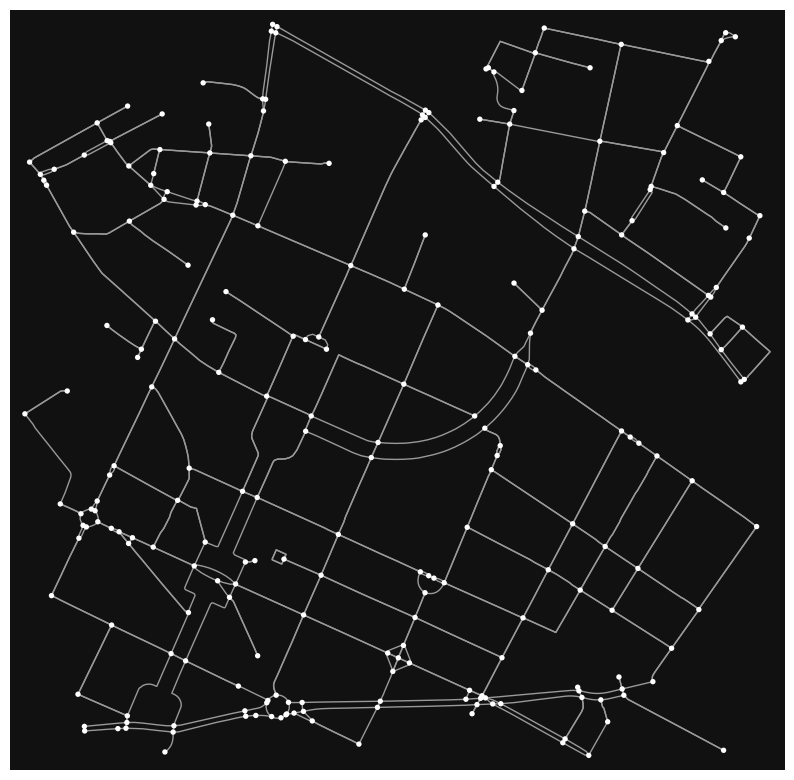

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [6]:
plot_network(berlin_network)

## Task 1: Bug-fixed code

This is a running version of the original code. This was not used for any analysis but only included to show that this code can run.

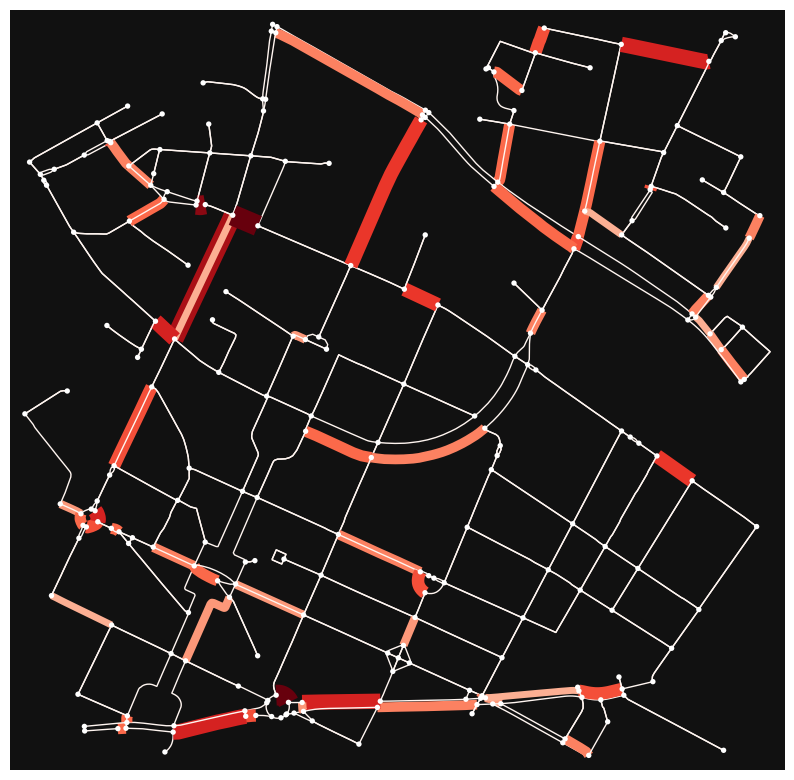

In [7]:
class Car:
  '''
    blueprint for all car objects. called to create new car objects for the simulation.
  '''
  def __init__(self, start, destination):
    '''
      initializes a new car object.

      parameters:
        start (node object): the starting node of the car
        destination (node object): the destination node of the car

      returns:
        none
    '''
    self.current_location = start
    self.destination = destination
    self.path = []

# the cars list is only created in the simulate_traffic but then we cannot access it. let us just wrap everything into one class
class TrafficSimulation:
  '''
    blueprint for all simulation objects. called to create a new simulation.
  '''
  def __init__(self, G, num_cars=100, num_steps = 100):
    '''
      initializes a new simulation object.

      parameters:
        G (networkx object): the given network the simulation is to be run on
        num_cars (int): the number of cars in the simulation
        num_steps (int): the number of steps the simulation will run for

      returns:
        none
    '''
    self.G = G
    self.num_cars = num_cars
    self.num_steps = num_steps
    self.cars = [] # a list to store the Car objects

  def initialize(self):
    '''
      sets up the simulation by placing cars in the street network.

      parameters:
        G (networkx object): the given network the simulation is to be run on
        num_cars (int): the number of cars in the simulation
        num_steps (int): the number of steps the simulation will run for

      returns:
        none
    '''
    # getting all the nodes
    nodes = list(self.G.nodes())

    # choosing a random start and destination for each car
    for _ in range(self.num_cars):
      start_loc = random.choice(nodes)
      destination_loc = random.choice(nodes)

      # ensuring that start and destination nodes are connected and that start ≠ destination
      while start_loc == destination_loc or not nx.has_path(self.G, start_loc, destination_loc):
        start_loc = random.choice(nodes)
        destination_loc = random.choice(nodes)

      # add car with its 'route' to the list
      self.cars.append(Car(start_loc, destination_loc))

    # calculating edge weights
    for u, v, k, data in self.G.edges(data=True, keys=True):
      # getting the speedlimit for every street and use 30km/h if missing
      speed = data.get("maxspeed", 30)
      if isinstance(speed, list):  # there can be multiple speed limits
          speed = speed[0] # take the first one as representative
      data["travel_time"] = data["length"] / (float(speed) * 1000/60) # length in meters, speed in km/h, result in minutes


  def move_cars(self):
    '''
      determines the paths for each car and moves them synchronously in the simulation.
    '''
    for car in self.cars:
      # move all cars sychronously every time step

        # calculate the car's route to the destination based on the current location
        if not car.path:
            car.path = nx.shortest_path(self.G, car.current_location, car.destination, weight="travel_time") # creates a list of nodes we are traveling on
            # get the next visited node
            if len(car.path) > 0:
              car.path.pop(0)

        # if the destination is reached, car remains in the destination
        if not car.path:
          continue

        # if the destination is not reached, get the next node to be visited
        next_node = car.path[0]

        # if there are more than 5 cars in one edge (street), traffic jam occurs
        # counting those cars that are currently in the same node and are moving to the same next node
        cars_on_edge = sum(1 for c in self.cars
                           if c.current_location == car.current_location # cars are in the same curr location
                           and c.path and c.path[0] == next_node) # cars are moving to the same next node
        if cars_on_edge > 3:
            car.path.insert(0, next_node)  # current car stays in the same spot
        else:
            # no traffic jam: car moves to the next location
            car.current_location = next_node
            car.path.pop(0) # remove the node the car just left from from the path

  def edge_car_counts(self):
    '''
      to model the traffic density along the road, this method
      determines the number of cars wanting to use a road.

      returns:
        counts (dict): a dictionary of each street and the number of cars wanting to use it
    '''
    # initiate a dictionary for each edge between all pairs of connected nodes
    counts = {(u, v, 0): 0 for u, v, _ in self.G.edges(keys=True)}

    # iterating through the cars and check all their next locations
    for car in self.cars:
        if car.path:
            next_node = car.path[0]
            # increase count of that specific edge
            counts[(car.current_location, next_node, 0)] += 1
    return counts


  def plot_network_with_traffic(self):
    '''
      plot the final state of the network with edge thickness and color representing
      the traffic density of each street.
    '''
    # initializing the edge widths and colors
    edge_colors = []
    edge_widths = []

    counts = self.edge_car_counts()
    # extract highest value
    max_val = max(counts.values()) if counts else 0
    max_count = max_val if max_val > 0 else 1 # avoiding division by 0

    # determining edge weights and colors
    for u, v, k, data in self.G.edges(data=True, keys=True):
        count = counts.get((u, v, k), 0)
        edge_colors.append(plt.cm.Reds(count / max_count))
        edge_widths.append(1 + count)

    # plot the graph
    fig, ax = ox.plot_graph(self.G, figsize=(10,10), edge_color=edge_colors, edge_linewidth=edge_widths)
    plt.show()

  def simulate_traffic(self):
    '''
      repeats the steps the of the simulation a specified amount of time.
    '''

    for step in range(self.num_steps):
        nodes = list(self.G.nodes())
        # move all cars one step in time
        self.move_cars()

G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
num_cars=500
num_steps = 100

simulation = TrafficSimulation(G, num_cars, num_steps)
simulation.initialize()
simulation.simulate_traffic()
simulation.plot_network_with_traffic()

## Task 2: Modified code

In [8]:
# setting seed for reproducibility
random.seed(42)

class Car:
  '''
    blueprint for all car objects. called to create new car objects for the simulation.
  '''
  def __init__(self, start, destination):
    '''
      initializes a new car object.

      parameters:
        start (node object): the starting node of the car
        destination (node object): the destination node of the car

      returns:
        none
    '''
    self.current_location = start
    self.destination = destination
    self.path = []

    # track progress along the current edge (0.0 to 1.0)
    # 0.0 = just entered the road, 1.0 = reached the end
    self.position = 0.0

class TrafficSimulation:
  '''
    blueprint for all simulation objects. called to create a new simulation.
  '''
  def __init__(self, G, num_cars=100, num_steps=100):
    '''
      initializes a new simulation object.

      parameters:
        G (networkx object): the given network the simulation is to be run on
        num_cars (int): the number of cars in the simulation
        num_steps (int): the number of steps the simulation will run for

      returns:
        none
    '''
    self.G = G
    self.num_cars = num_cars
    self.num_steps = num_steps
    self.cars = [] # a list to store the car objects
    self.capacity = {} # capacities of each street (edge) (u, v, k) -> C

  def initialize(self):
    '''
      sets up the simulation by placing cars in the street network.

      parameters:
        none

      returns:
        none
    '''
    # getting all the nodes
    nodes = list(self.G.nodes())

    # create cars with random but feasible trips
    for _ in range(self.num_cars):
      start_loc = random.choice(nodes)
      destination_loc = random.choice(nodes)

      # ensure start != destination and reachable
      while (start_loc == destination_loc or
              not nx.has_path(self.G, start_loc, destination_loc)):
        start_loc = random.choice(nodes)
        destination_loc = random.choice(nodes)

      # calculate initial path immediately
      new_car = Car(start_loc, destination_loc)
      new_car.path = nx.shortest_path(self.G, start_loc, destination_loc, weight="length")

      # remove start node (we are already there)
      if len(new_car.path) > 0:
        new_car.path.pop(0)

      self.cars.append(new_car)

    # compute travel_time and capacity for each edge
    vehicle_length = 9.0 # meters per car including gap

    for u, v, k, data in self.G.edges(data=True, keys=True):
      # travel_time from length and speed
      speed = data.get("maxspeed", 30)
      if isinstance(speed, list):
          speed = int(min(speed)) # if multiple speeds, take the lowest
      else:
          speed = int(speed)

      # calculate "base travel time" (how many steps to cross if empty)
      # length (m) / speed (km/h -> m/min). 1 step = 1 minute
      speed_mpm = speed * 1000.0 / 60.0
      length = float(data["length"])

      data["base_time"] = length / speed_mpm

      # edge capacity from physical length
      C = max(1, int(length / vehicle_length)) # max number of cars in the street
      self.capacity[(u, v, k)] = C

  def edge_car_counts(self):
    '''
      to model the traffic density along the road, this method
      determines the number of cars wanting to use a road.

      returns:
        counts (dict): a dictionary of each street and the number of cars wanting to use it
    '''
    # initiate a dictionary for each edge
    counts = {}
    for car in self.cars:
      if car.path:
        u = car.current_location
        v = car.path[0]
        # we need the key to identify the specific edge (multi-graph)
        if self.G.has_edge(u, v):
            # assume the first key available for simplicity
            key = list(self.G[u][v].keys())[0]
            counts[(u, v, key)] = counts.get((u, v, key), 0) + 1
    return counts

  def move_cars(self):
    '''
      determines the paths for each car and moves them synchronously in the simulation.
    '''
    # compute edge counts once per time step
    edge_counts = self.edge_car_counts()

    for car in self.cars:
      # skip cars already at destination
      if not car.path:
        continue

      # identify the edge the car is currently driving on
      u = car.current_location # current node
      v = car.path[0] # next node

      if not self.G.has_edge(u, v):
          continue

      k = list(self.G[u][v].keys())[0] # get the edge key
      edge_id = (u, v, k)

      # get properties
      n_cars = edge_counts.get(edge_id, 1) # current cars (including self)
      capacity = self.capacity.get(edge_id, 1) # street capacity
      base_time = self.G.edges[u, v, k]["base_time"] # base time (given no traffic)

      # calculate car density (rho)
      rho = n_cars / capacity
      if rho > 1.0: rho = 1.0 # limit to 1

      # speed factor = 1.0 (empty) -> 0.1 (jammed)
      # formula: v = v_max * (1 - rho)
      speed_factor = max(0.1, 1.0 - rho)

      # calculate progress of this car on the specific road
      base_speed_per_step = 1.0 / base_time

      # apply traffic penalty
      actual_speed = base_speed_per_step * speed_factor

      # move the car
      car.position += actual_speed

      # check arrival
      if car.position >= 1.0:
        # arrived at node 'v'
        car.current_location = v
        car.path.pop(0) # remove visited node
        car.position = 0.0 # reset for next road


  def plot_network_with_traffic(self, legend_plot=True):
    '''
      plot the final state of the network with edge thickness and color representing
      the traffic density of each street.
      adds a colorbar and uses green-yellow-red scale.
    '''
    # initializing the edge widths and colors
    edge_colors = []
    edge_widths = []

    counts = self.edge_car_counts()

    # determining edge weights and colors
    for u, v, k, data in self.G.edges(data=True, keys=True):
      count = counts.get((u, v, k), 0)
      capacity = self.capacity.get((u, v, k), 1)

      # density = count / capacity
      density = count / capacity
      if density > 1.0: density = 1.0

      if count > 0:
        # traffic coloring (green is empty, yellow mid, )
        color = plt.cm.RdYlGn_r(density)
        edge_colors.append(color)
        edge_widths.append(1.0 + (density * 2.0))
      else:
        # no traffic: use grey
        edge_colors.append(plt.cm.Grays(0.3))
        edge_widths.append(0.6)

    # plot the graph
    fig, ax = ox.plot_graph(self.G,
                            node_size=0,
                            node_color="grey",
                            figsize=(10,10),
                            edge_color=edge_colors,
                            edge_linewidth=edge_widths,
                            bgcolor='white',
                            show=False, close=False)

    if legend_plot:
      # add colorbar
      sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=plt.Normalize(vmin=0, vmax=1))
      sm._A = []
      cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
      cbar.set_label('Traffic Density (Cars / Capacity)')
      cbar.set_ticks([0, 0.5, 1])
      cbar.set_ticklabels(['Free Flow', 'Busy', 'Jammed'])

    # add title
    total_cars_moving = sum(counts.values())
    #ax.set_title(f"Step {self.step_count}: {total_cars_moving} cars moving", color="black")
    plt.show()

  def simulate_traffic(self):
    '''
      repeats the steps the of the simulation a specified amount of time.
    '''
    self.step_count = 0 # track steps
    for step in range(self.num_steps):
        self.step_count = step
        # move all cars one step in time
        self.move_cars()

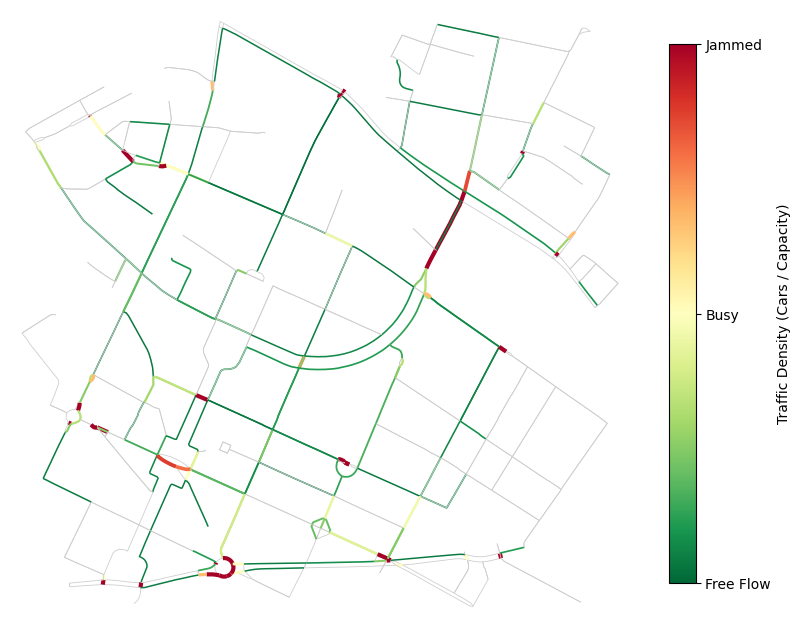

In [9]:
# plotting a static image of the improved visualization
G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
sim = TrafficSimulation(G, num_cars=500, num_steps=4)
sim.initialize()
sim.simulate_traffic()
sim.plot_network_with_traffic()

## Test Cases


--- TEST CASE 1: plotting 1 car by 1 step ---
   (rho=0.0080, expected_pos=0.9920)
Position after 1 step: 0.9920
✅ PASS

--- TEST CASE 2: car slows down on busy road ---
Density: 1.00
Car Progress: 0.0500 (Expected: 0.05)
✅ PASS: Car crawled at ~5% progress.

--- TEST CASE 3: Shortest Path Logic ---
Calculated Path: [1, 3]
✅ PASS: Car chose the shortest route (via Node 1).


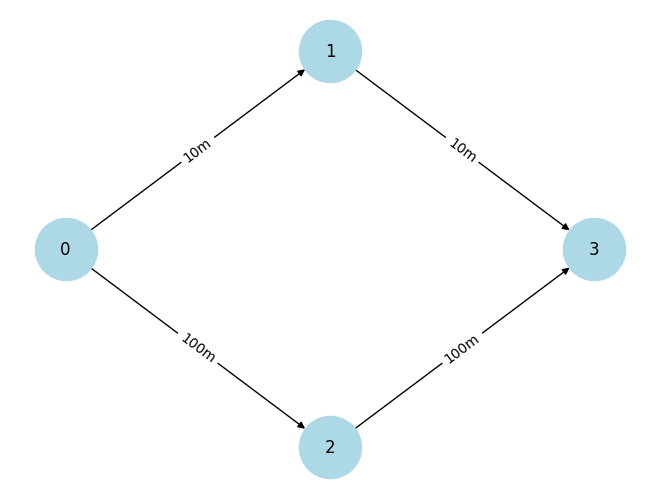

In [10]:
def create_test_graph(length=1000, speed_kmh=60):
    '''
    creates a simple one-way road from node 0 to node 1.
    length is in meters, speed in km/h.
    '''
    G = nx.MultiDiGraph()
    G.add_node(0, x=0, y=0)
    G.add_node(1, x=length, y=0)
    G.add_edge(0, 1, key=0, length=length, maxspeed=speed_kmh)
    return G

def test_free_flow():
    print("\n--- TEST CASE 1: plotting 1 car by 1 step ---")
    # setup: 1km road, 60km/h speed limit
    G = create_test_graph(length=1000, speed_kmh=60)
    sim = TrafficSimulation(G, num_cars=1, num_steps=1)

    # manually place 1 car
    sim.cars = []
    car = Car(0, 1)
    car.path = [1]
    car.position = 0.0
    sim.cars.append(car)

    # run initialize()) to compute base_time
    u, v, k = 0, 1, 0
    data = G.edges[u, v, k]
    speed_mpm = 60 * 1000 / 60.0
    data['base_time'] = 1000 / speed_mpm
    capacity = int(1000 / 8.0)
    sim.capacity[(u,v,k)] = capacity

    # expected result:
    rho = 1 / capacity
    expected_speed_factor = 1.0 - rho
    print(f"   (rho={rho:.4f}, expected_pos={expected_speed_factor:.4f})")

    # run 1 step (car should move ahead)
    sim.move_cars()

    print(f"Position after 1 step: {car.position:.4f}")

    if abs(car.position - expected_speed_factor) < 0.001:
        print("✅ PASS")
    else:
        print(f"❌ FAIL pos ={car.position})")

def test_gridlock():
    print("\n--- TEST CASE 2: car slows down on busy road ---")
    # create longer distance
    G = create_test_graph(length=2000, speed_kmh=60)

    # capacity = 2000m / 8m = 250 cars
    capacity = int(2000 / 8.0)
    sim = TrafficSimulation(G, num_cars=capacity, num_steps=1)

    # edge data
    u, v, k = 0, 1, 0
    data = G.edges[u, v, k]
    speed_mpm = 60 * 1000 / 60.0 # 1000 m/min
    data['base_time'] = 2000 / speed_mpm # exactly 2.0 minutes to cross
    sim.capacity[(u,v,k)] = capacity

    # fill road with max cars
    sim.cars = []
    for i in range(capacity):
        c = Car(0, 1)
        c.path = [1]
        c.position = 0.0
        sim.cars.append(c)

    # run 1 step
    sim.move_cars()

    test_car = sim.cars[0]

    # EXPECTED:
      # base speed = 1000 m/min.
      # jammed speed = 10% of 1000 = 100 m/min.
      # road length = 2000 m.
      # progress = 100m / 2000m = 0.05

    print(f"Density: {len(sim.cars)/capacity:.2f}")
    print(f"Car Progress: {test_car.position:.4f} (Expected: 0.05)")

    if 0.04 < test_car.position < 0.06:
        print("✅ PASS: Car crawled at ~5% progress.")
    else:
        print(f"❌ FAIL. Pos: {test_car.position})")

def test_shortest_path_selection():
    print("\n--- TEST CASE 3: Shortest Path Logic ---")

    # create simple graph to check if cars actually take the shortest route
    G = nx.MultiDiGraph()
    G.add_nodes_from([0, 1, 2, 3])

    # path A (short): 0 -> 1 -> 3 (Total 20m)
    G.add_edge(0, 1, key=0, length=10.0, maxspeed=50)
    G.add_edge(1, 3, key=0, length=10.0, maxspeed=50)

    # path B (long): 0 -> 2 -> 3 (Total 200m)
    G.add_edge(0, 2, key=0, length=100.0, maxspeed=50)
    G.add_edge(2, 3, key=0, length=100.0, maxspeed=50)

    # 1 car on simulation
    sim = TrafficSimulation(G, num_cars=1, num_steps=1)

    # car goes from 0 to 3 (ideally through the short path)
    car = Car(0, 3) # Start at 0, Dest at 3

    # use nx.shortest_path
    car.path = nx.shortest_path(G, 0, 3, weight="length")
    if len(car.path) > 0:
        car.path.pop(0)

    print(f"Calculated Path: {car.path}")

    # the path should be [1, 3] (short way)
    if car.path == [1, 3]:
        print("✅ PASS: Car chose the shortest route (via Node 1).")
    elif car.path == [2, 3]:
        print("❌ FAIL: Car chose the long route (via Node 2).")
    else:
        print(f"❌ FAIL. Path: {car.path}")

    # visualize
    pos = {0: (0,0), 1: (1,1), 2: (1,-1), 3: (2,0)}
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(0,1):'10m', (1,3):'10m', (0,2):'100m', (2,3):'100m'})
    plt.show()

# run test cases
test_free_flow()
test_gridlock()
test_shortest_path_selection()

## Empirical Analysis

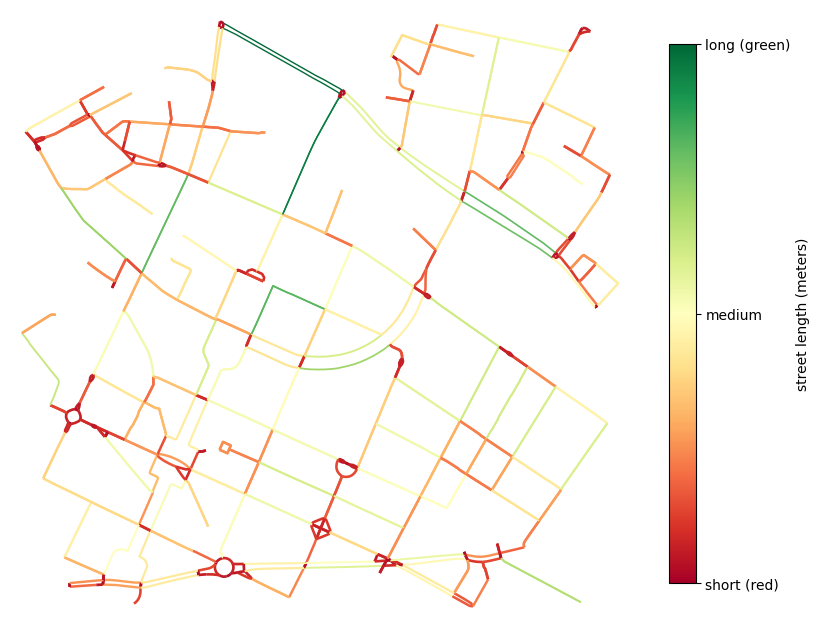

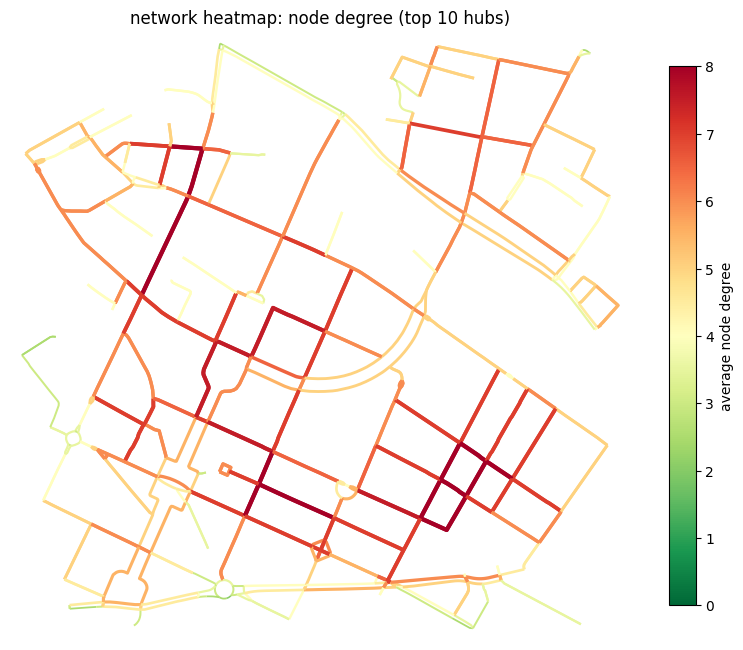

  #1: Engeldamm (u=29276213, v=29276217, val=0.14)
  #2: Bethaniendamm (u=29276209, v=29276213, val=0.14)
  #3: Bethaniendamm (u=3243910627, v=29276213, val=0.13)
  #4: Bethaniendamm (u=29273064, v=29276209, val=0.13)
  #5: Bethaniendamm (u=29276213, v=29276209, val=0.13)
  #6: Bethaniendamm (u=29276209, v=29273064, val=0.13)
  #7: An der Schillingbrücke (u=29273065, v=29273064, val=0.12)
  #8: Waldemarstraße (u=29218296, v=29218295, val=0.11)
  #9: Kottbusser Tor (u=29217325, v=29217322, val=0.09)
  #10: Kottbusser Tor (u=29217322, v=29217321, val=0.09)
  #11: Heinrich-Heine-Straße (u=29218293, v=21487232, val=0.09)
  #12: Bethaniendamm (u=29276211, v=3243910627, val=0.09)
  #13: An der Schillingbrücke (u=29273064, v=29273065, val=0.09)
  #14: Engeldamm (u=29276217, v=29276222, val=0.08)
  #15: Engeldamm (u=29276222, v=29218323, val=0.08)


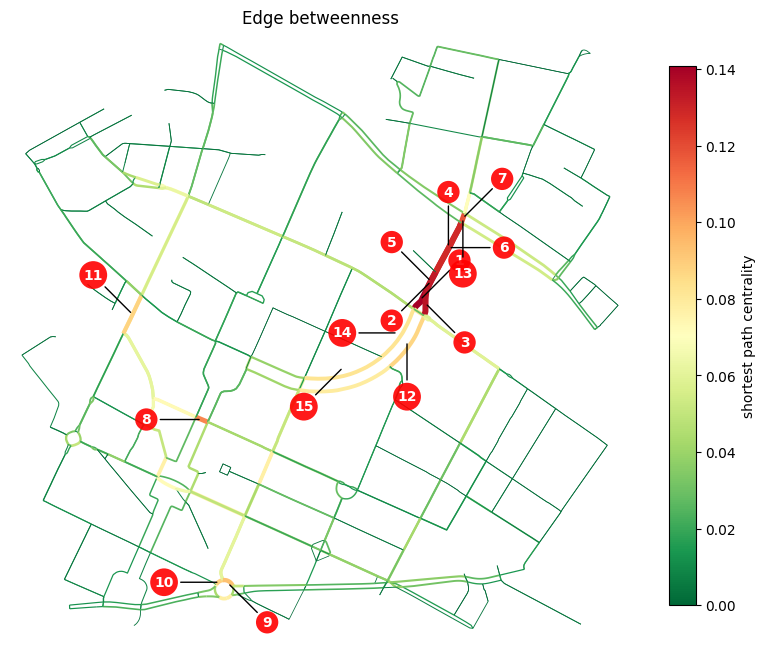

  #1: Kottbusser Tor (u=268466879, v=11806567841, val=0.08)
  #2: Kottbusser Tor (u=11806567841, v=29217327, val=0.08)
  #3: Kottbusser Tor (u=29217321, v=29217332, val=0.08)
  #4: Oranienstraße (u=29276750, v=536286819, val=0.05)
  #5: Oranienstraße (u=536286819, v=29276750, val=0.04)
  #6: An der Schillingbrücke (u=29273065, v=29273064, val=0.04)
  #7: Kottbusser Tor (u=29217340, v=268466879, val=0.04)
  #8: Holzmarktstraße (u=26960758, v=29271261, val=0.04)
  #9: Köpenicker Straße (u=28373656, v=3352479275, val=0.03)
  #10:  (u=13233583767, v=29215047, val=0.03)
  #11: Köpenicker Straße (u=3352479272, v=28373656, val=0.03)
  #12: Kottbusser Tor (u=29217322, v=29217321, val=0.03)
  #13: Mühlenstraße (u=3242035261, v=29275853, val=0.03)
  #14: Inselstraße (u=3352479290, v=3463840860, val=0.03)
  #15: An der Schillingbrücke (u=29273064, v=29273065, val=0.03)


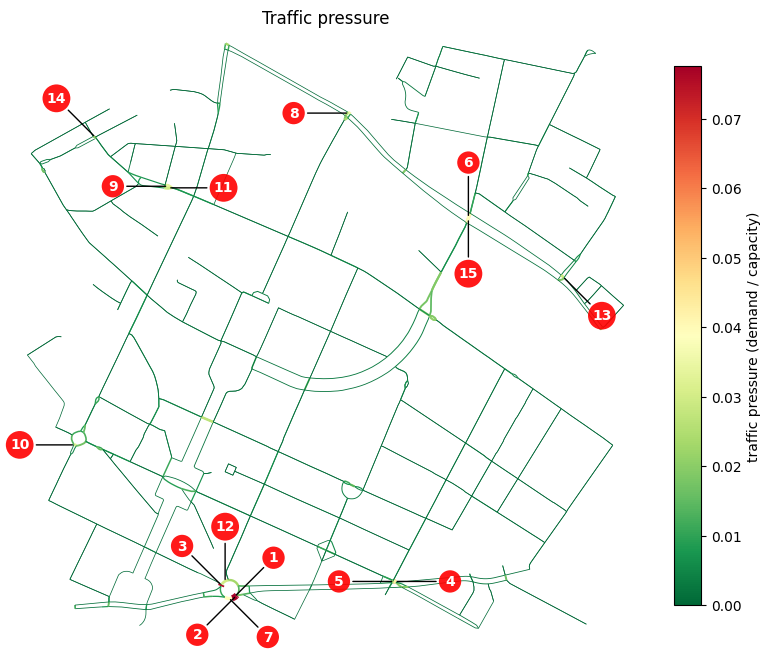

In [11]:
def plot_structural_heatmaps(G):
    '''
    plots four heatmaps of the network structure with top 10 labels.
    prints u and v ids for strict comparison with empirical results.
    1. by street length (short = red)
    2. by node degree (hubs = red)
    3. by edge betweenness (high usage = red)
    4. by traffic pressure (bottlenecks = red)
    '''

    # helper function to apply the labeling logic to any plot
    def _add_top_labels(ax, edge_data_list, top_n=10):
        # convert to dataframe for easy sorting
        df = pd.DataFrame(edge_data_list)
        # sort descending (highest value first)
        top_edges = df.sort_values(by='val', ascending=False).head(top_n).reset_index()

        # collision avoidance setup (because labels often overlap)
        placed_label_coords = []
        # determine location in terms of radius (0-360 deg)
        candidate_angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
        radius = 40

        # iterate through all df rows
        for rank, row in top_edges.iterrows():
            rank_num = rank + 1
            u, v = int(row['u']), int(row['v'])
            name = row['name']
            # extract edge name
            if isinstance(name, list): name = name[0]
            val = row['val']

            # calculate midpoint between nodes (middle of the edge)
            x_u, y_u = G.nodes[u]['x'], G.nodes[u]['y']
            x_v, y_v = G.nodes[v]['x'], G.nodes[v]['y']
            mid_x = (x_u + x_v) / 2 # mid x coordinate
            mid_y = (y_u + y_v) / 2 # mid y coordinate

            # collision avoidance logic
            best_angle = 0
            max_dist = -1

            if not placed_label_coords:
                best_angle = np.pi / 4
            else:
                for angle in candidate_angles:
                    check_x = mid_x + np.cos(angle) * 0.002
                    check_y = mid_y + np.sin(angle) * 0.002

                    min_dist_to_others = float('inf')
                    for (px, py) in placed_label_coords:
                        dist = np.sqrt((check_x - px)**2 + (check_y - py)**2)
                        if dist < min_dist_to_others:
                            min_dist_to_others = dist

                    if min_dist_to_others > max_dist:
                        max_dist = min_dist_to_others
                        best_angle = angle

            offset_x = radius * np.cos(best_angle)
            offset_y = radius * np.sin(best_angle)
            placed_label_coords.append((mid_x + np.cos(best_angle)*0.002,
                                        mid_y + np.sin(best_angle)*0.002))

            # annotate
            ax.annotate(
                text=str(rank_num),
                xy=(mid_x, mid_y),
                xytext=(offset_x, offset_y),
                textcoords='offset points',
                fontsize=10, color='white', weight='bold', ha='center', va='center',
                bbox=dict(boxstyle="circle,pad=0.3", fc="red", ec="none", alpha=0.9),
                arrowprops=dict(arrowstyle="-", color="black", lw=1.0)
            )

            # print with u and v ids
            print(f"  #{rank_num}: {name} (u={u}, v={v}, val={val:.2f})")

    # plot 1: street length

    edge_data = [] # collect data for labeling
    lengths = []

    # iterate through all edges
    for u, v, k, data in G.edges(data=True, keys=True):
        length = data.get('length', 0) # extract length
        lengths.append(length)
        edge_data.append({'u':u, 'v':v, 'name':data.get('name',''), 'val':length})

    max_len = max(lengths)
    edge_colors = []
    edge_widths = []

    # coloring based on the length
    for length in lengths:
        val = length / max_len
        # short=red, long=green
        edge_colors.append(plt.cm.RdYlGn(val))
        edge_widths.append(2.0 - val)

    # plot length-heatmap
    fig, ax = ox.plot_graph(G, node_size=0, figsize=(10,10),
                            edge_color=edge_colors, edge_linewidth=edge_widths,
                            bgcolor='white', show=False, close=False)


    # plot colormap
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=max_len))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('street length (meters)')
    cbar.set_ticks([0, max_len/2, max_len])
    cbar.set_ticklabels(['short (red)', 'medium', 'long (green)'])
    plt.show()

    # plot 2: average degree
    # extract degrees of nodes
    degree_dict = dict(G.degree())
    max_degree = max(degree_dict.values()) # max value for normalization
    edge_data = []
    edge_colors = []
    edge_widths = []

    # iterate through nodes
    for u, v, k, data in G.edges(data=True, keys=True):
      # calculate average degree of start and end nodes of an edge
        avg_deg = (degree_dict[u] + degree_dict[v]) / 2.0
        edge_data.append({'u':u, 'v':v, 'name':data.get('name',''), 'val':avg_deg})
        # normalize
        val = avg_deg / max_degree
        # color based on the degree ratio
        edge_colors.append(plt.cm.RdYlGn_r(val))
        edge_widths.append(0.5 + val * 2.5)

    # plot on map
    fig, ax = ox.plot_graph(G, node_size=0, figsize=(10,10),
                            edge_color=edge_colors, edge_linewidth=edge_widths,
                            bgcolor='white', show=False, close=False)

    # plot colorscale
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=plt.Normalize(vmin=0, vmax=max_degree))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('average node degree')
    ax.set_title("network heatmap: node degree (top 10 hubs)", color="black")
    plt.show()

    # plot 3: edge betweenness

    # create a dict for the betweenness centrality
    betweenness_dict = nx.edge_betweenness_centrality(G, weight='length')
    max_bet = max(betweenness_dict.values()) if betweenness_dict else 1.0

    edge_data = []
    edge_colors = []
    edge_widths = []

    # iterate through edges and normalize
    for u, v, k, data in G.edges(data=True, keys=True):
        val = betweenness_dict.get((u, v, k), betweenness_dict.get((u, v), 0))
        edge_data.append({'u':u, 'v':v, 'name':data.get('name',''), 'val':val})

        norm_val = val / max_bet
        edge_colors.append(plt.cm.RdYlGn_r(norm_val))
        edge_widths.append(0.5 + norm_val * 4.0)

    # plot on map
    fig, ax = ox.plot_graph(G, node_size=0, figsize=(10,10),
                            edge_color=edge_colors, edge_linewidth=edge_widths,
                            bgcolor='white', show=False, close=False)

    # label top 15 roads with highest epsilon
    _add_top_labels(ax, edge_data, top_n=15)

    # plot colorscale
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=plt.Normalize(vmin=0, vmax=max_bet))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('shortest path centrality')
    ax.set_title("Edge betweenness", color="black")
    plt.show()

    #  plot 4: traffic pressure

    # setup
    edge_data = []
    edge_colors = []
    edge_widths = []
    pressures = []

    # calculate pressure
    temp_pressures = {}

    # iterate through nodes and divide betweenness by capacity
    for u, v, k, data in G.edges(data=True, keys=True):
        bet = betweenness_dict.get((u, v, k), betweenness_dict.get((u, v), 0))
        length = data.get('length', 50)

        # calculation of the new metric
        capacity = max(1, int(length / 9.0))
        pressure = bet / capacity

        temp_pressures[(u, v, k)] = pressure
        pressures.append(pressure)
        edge_data.append({'u':u, 'v':v, 'name':data.get('name',''), 'val':pressure})

    max_pressure = max(pressures) if pressures else 1.0

    # normalize each value
    for u, v, k in G.edges(keys=True):
        pressure = temp_pressures.get((u, v, k), 0)
        norm_val = pressure / max_pressure
        # color based on normalized value
        edge_colors.append(plt.cm.RdYlGn_r(norm_val))
        edge_widths.append(0.5 + norm_val * 4.0)

    # plot on map
    fig, ax = ox.plot_graph(G, node_size=0, figsize=(10,10),
                            edge_color=edge_colors, edge_linewidth=edge_widths,
                            bgcolor='white', show=False, close=False)

    # add top 15 highest values
    _add_top_labels(ax, edge_data, top_n=15)

    # add color scale legend
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=plt.Normalize(vmin=0, vmax=max_pressure))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('traffic pressure (demand / capacity)')
    ax.set_title("Traffic pressure", color="black")
    plt.show()

#  execute code!
G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
plot_structural_heatmaps(G)

In [12]:
random.seed(123)
def run_congestion_analysis(G,
                            max_trials=1000,
                            min_trials=10,
                            convergence_tol=1e-4, # 0.01%
                            patience=5,
                            num_steps=100,
                            top_n=300,
                            progress_bar=True):
    '''
    runs simulation until the worst road's percentage change drops below tolerance.
    excludes empty roads (zeros) from the percentage calculation.

    parameters:
        G (networkx graph): road network.
        max_trials (int): maximum number of trials to run.
        min_trials (int): minimum number of trials to run.
        convergence_tol (float): stop when max % change < this (e.g. 0.0001 = 0.01%).
        patience (int): the number of consecutive trials the change must be < convergence_tol.
        num_steps (int): how long to run the simulation.
        top_n (int): number of top congested roads to display.

    retirms:
      df (pandas dataframe): full dataset (for analysis).
      top_congested (pandas dataframe): top congested roads (for reporting
    '''

    # initialize average values data as a dictionary
    global_density_sums = {key: 0.0 for u, v, k in G.edges(keys=True) for key in [(u, v, k)]}

    # stores average density from previous trial
    prev_edge_means = {key: 0.0 for u, v, k in G.edges(keys=True) for key in [(u, v, k)]}

    # counting how many trials are needed to reach stable mean values
    stable_trials = 0

    # track the maximum percentage change at each step
    history_max_pct = []

    trial = 0
    while trial < max_trials:
        # run single simulation
        sim = TrafficSimulation(G, num_cars=1000, num_steps=num_steps)
        sim.initialize()

        # run simulation step by step
        for step in range(num_steps):
            sim.move_cars()
            counts = sim.edge_car_counts()

            # extract the density of each street at each step
            for u, v, k in G.edges(keys=True):
                edge_id = (u, v, k)
                count = counts.get(edge_id, 0)
                capacity = sim.capacity.get(edge_id, 1)

                density = count / capacity
                if density > 1.0: density = 1.0

                global_density_sums[edge_id] += density

            # stop if all cars have reached their destination
            active = [c for c in sim.cars if c.path]
            if not active: break

        # convergence check
        trial += 1

        # total points (renormalization constant for mean)
        total_time_points = trial * num_steps

        # variable storing the maximal percentage change of a road each trial
        max_pct_change = 0.0

        for u, v, k in G.edges(keys=True):
            edge_id = (u, v, k)
            curr_mean = global_density_sums[edge_id] / total_time_points
            prev_mean = prev_edge_means[edge_id]

            # only calculate percentage if previous mean was non-zero
            # this "excludes the zeros" as requested
            if prev_mean > 1e-9:
                pct_change = abs(curr_mean - prev_mean) / prev_mean

                if pct_change > max_pct_change:
                    max_pct_change = pct_change

            # update previous for next time
            prev_edge_means[edge_id] = curr_mean

        history_max_pct.append(max_pct_change)

        # check tolerance (only after min_trials)
        if trial > min_trials:
            if max_pct_change < convergence_tol:
                stable_trials += 1
            else:
                stable_trials = 0

        if progress_bar:
            status = f"trial {trial}: max_%_change={max_pct_change:.4%} | stable={stable_trials}/{patience}"
            print(f"\r{status}", end="")

        if stable_trials >= patience:
            print(f"\n> strict percentage convergence reached! stopping at trial {trial}.")
            break

    if trial >= max_trials:
        print("\n> max trials reached without full convergence.")

    # process final results
    print("\nprocessing final dataset...")
    results = []
    max_avg_density = 0

    # iterate through all the edges
    for u, v, k, data in G.edges(data=True, keys=True):
        edge_id = (u, v, k)
        avg_density = prev_edge_means[edge_id]

        # update and identify the max percentage change in any simulation run
        if avg_density > max_avg_density:
            max_avg_density = avg_density

        # extract the names of the street
        name = data.get("name", "unknown")
        if isinstance(name, list): name = name[0]

        # store results
        results.append({
            "u": u, "v": v, "key": k, "name": name,
            "avg_density": avg_density, "length": data.get("length", 0)
        })

    # identify top congested roads
    df = pd.DataFrame(results)
    top_congested = df.sort_values(by="avg_density", ascending=False).head(top_n)

    print("\n" + "="*40)
    print(f"TOP CONGESTED ROADS")
    print("="*40)
    print(top_congested[['name', 'avg_density', 'length']].head(10))

    # plot convergence history (log scale for percentages)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(history_max_pct) + 1), history_max_pct, color='darkred', linewidth=0.8)
    plt.xlabel("Number of Trials")
    plt.hlines(1e-2, 0, len(history_max_pct), linestyles='--', colors='red')
    plt.ylabel("Max % Change in Any Road")
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

    # visualize
    edge_colors = []
    edge_widths = []
    if max_avg_density == 0: max_avg_density = 1.0

    # iterate through edges and assign colors
    for u, v, k in G.edges(keys=True):
        edge_id = (u, v, k)
        avg_density = prev_edge_means[edge_id]
        relative_density = avg_density / max_avg_density

        # colors and width depends on relative_density
        if avg_density > 0:
            edge_colors.append(plt.cm.RdYlGn_r(relative_density))
            edge_widths.append(1.0 + relative_density * 3.0)
        else:
            edge_colors.append(plt.cm.Greys(0.2))
            edge_widths.append(0.5)

    # final graph and heatmap plot
    fig, ax = ox.plot_graph(G, node_size=0, figsize=(10,10),
                            edge_color=edge_colors, edge_linewidth=edge_widths,
                            bgcolor='white', show=False, close=False)

    # add a legend to the side
    norm = plt.Normalize(vmin=0, vmax=max_avg_density)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('average traffic density')
    plt.show()

    return df, top_congested

trial 960: max_%_change=0.3648% | stable=10/10
> strict percentage convergence reached! stopping at trial 960.

processing final dataset...

TOP CONGESTED ROADS
                       name  avg_density      length
545          Kottbusser Tor     0.214406    3.208236
100          Kottbusser Tor     0.213656    6.907021
370          Kottbusser Tor     0.213385   15.797159
39        Köpenicker Straße     0.202677   24.595416
132          Waldemarstraße     0.197713  157.299920
418           Oranienstraße     0.189583   10.745022
102          Kottbusser Tor     0.183177   27.314989
109          Kottbusser Tor     0.182698   26.118733
489             Inselstraße     0.180854    4.284425
204  An der Schillingbrücke     0.170896   34.915946


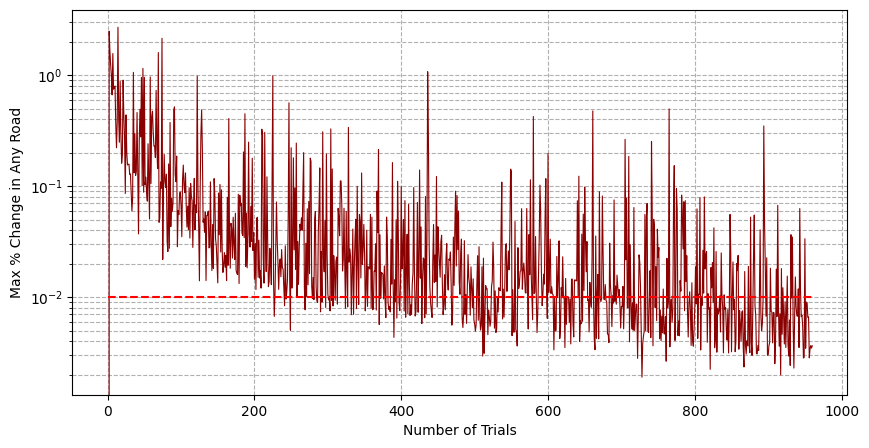

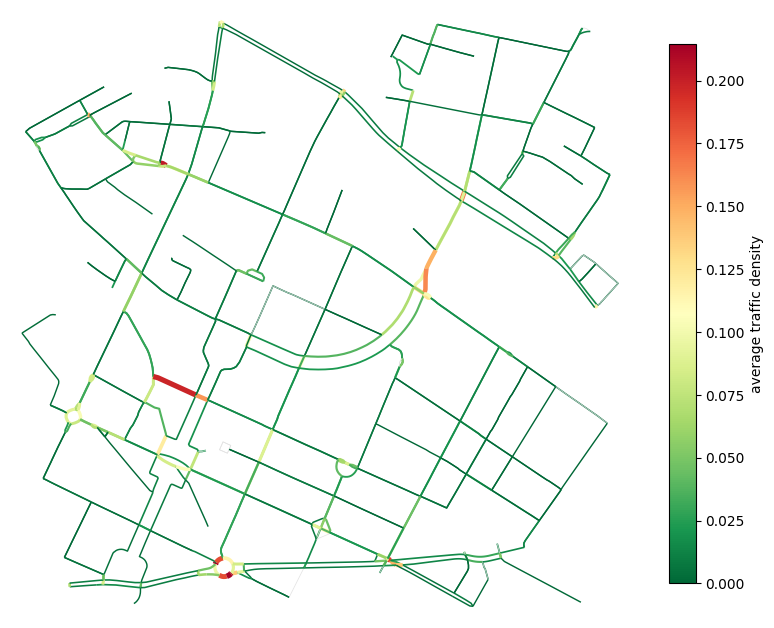

In [13]:
G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
all_roads, top_roads = run_congestion_analysis(G,
                            max_trials=1200,
                            min_trials=10,
                            convergence_tol=1e-2, # 1%
                            patience=10,
                            num_steps=100,
                            top_n=300,
                            progress_bar=True)

In [14]:
all_roads.sort_values(by='avg_density', ascending=False).head(15)

,u,v,key,name,avg_density,length
545,11806567841,29217327,0,Kottbusser Tor,0.214406,3.208236
100,29217321,29217332,0,Kottbusser Tor,0.213656,6.907021
370,268466879,11806567841,0,Kottbusser Tor,0.213385,15.797159
39,28373656,3352479275,0,Köpenicker Straße,0.202677,24.595416
132,29218295,29218291,0,Waldemarstraße,0.197713,157.299920
418,536286819,29276750,0,Oranienstraße,0.189583,10.745022
102,29217322,29217321,0,Kottbusser Tor,0.183177,27.314989
109,29217340,268466879,0,Kottbusser Tor,0.182698,26.118733
489,3352479290,3463840860,0,Inselstraße,0.180854,4.284425
204,29273064,29273065,0,An der Schillingbrücke,0.170896,34.915946


mapping top 15 hotspots (with collision avoidance)...


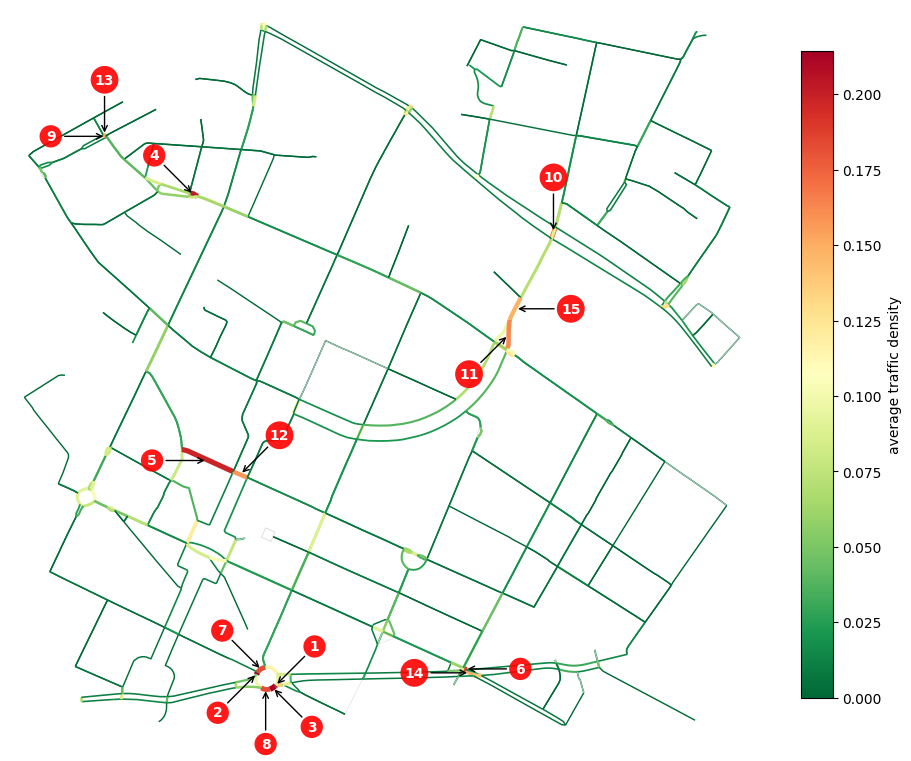

In [15]:
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np

def plot_congested_with_ranks(G, df_results, top_n=20):
    '''
    plots the congestion map and labels the top n hotspots with their rank.
    includes a basic collision avoidance algorithm to prevent overlapping labels.
    '''
    # prepare data & colors
    max_density = df_results['avg_density'].max() # extract maximum density along all trials
    if max_density == 0: max_density = 1.0

    # lookup dict
    density_map = df_results.set_index(['u', 'v', 'key'])['avg_density'].to_dict()

    edge_colors = []
    edge_widths = []

    for u, v, k in G.edges(keys=True):
        avg_density = density_map.get((u, v, k), 0.0)
        relative_density = avg_density / max_density

        if avg_density > 0:
            edge_colors.append(plt.cm.RdYlGn_r(relative_density))
            edge_widths.append(1.0 + relative_density * 3.0)
        else:
            edge_colors.append(plt.cm.Greys(0.2))
            edge_widths.append(0.5)

    # 2. plot the base graph
    fig, ax = ox.plot_graph(G, node_size=0, figsize=(12,12),
                            edge_color=edge_colors, edge_linewidth=edge_widths,
                            bgcolor='white', show=False, close=False)

    # 3. label the top n ranks
    top_roads = df_results.sort_values(by='avg_density', ascending=False).head(top_n).reset_index()

    print(f"mapping top {top_n} hotspots (with collision avoidance)...")

    # store the final (x, y) map coordinates of labels we have placed
    placed_label_coords = []

    # possible offsets (angles in radians)
    # 0=right, pi/2=up, pi=left, etc.
    candidate_angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
    radius = 40 # distance in "points" (pixels) from the street center

    for rank, row in top_roads.iterrows():
        rank_num = rank + 1
        u, v = row['u'], row['v']

        # calculate target point (street center)
        x_u, y_u = G.nodes[u]['x'], G.nodes[u]['y']
        x_v, y_v = G.nodes[v]['x'], G.nodes[v]['y']
        mid_x = (x_u + x_v) / 2
        mid_y = (y_u + y_v) / 2

        # collision avoidance logic
        best_angle = 0
        max_dist = -1

        # if this is the first label, just pick top-right (pi/4)
        if not placed_label_coords:
            best_angle = np.pi / 4
        else:
            # check all 8 candidate positions
            for angle in candidate_angles:
                # approximate the new label's map position
                # (this is rough because 'radius' is in pixels, but good enough for heuristics)
                # we use a small factor (0.002) to convert pixels to lat/lon roughly
                check_x = mid_x + np.cos(angle) * 0.002
                check_y = mid_y + np.sin(angle) * 0.002

                # find distance to the nearest existing label
                min_dist_to_others = float('inf')
                for (px, py) in placed_label_coords:
                    dist = np.sqrt((check_x - px)**2 + (check_y - py)**2)
                    if dist < min_dist_to_others:
                        min_dist_to_others = dist

                # we want the angle that maximizes the distance to the nearest neighbor
                if min_dist_to_others > max_dist:
                    max_dist = min_dist_to_others
                    best_angle = angle

        # calculate final offset in pixels based on best angle
        offset_x = radius * np.cos(best_angle)
        offset_y = radius * np.sin(best_angle)

        # save this position so future labels avoid it
        # (again, roughly converting pixel offset back to map coords for the logic)
        placed_label_coords.append((mid_x + np.cos(best_angle)*0.002,
                                    mid_y + np.sin(best_angle)*0.002))

        # annotate
        ax.annotate(
            text=str(rank_num),
            xy=(mid_x, mid_y),
            xytext=(offset_x, offset_y),
            textcoords='offset points',
            fontsize=10, color='white', weight='bold', ha='center', va='center',
            bbox=dict(boxstyle="circle,pad=0.3", fc="red", ec="none", alpha=0.9),
            arrowprops=dict(arrowstyle="->", color="black", lw=1.0)
        )

    # add colorbar
    norm = plt.Normalize(vmin=0, vmax=max_density)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('average traffic density')

    plt.show()

# running it
plot_congested_with_ranks(G, all_roads, top_n=15)

In [16]:
summarized_view = all_roads.sort_values(by='avg_density', ascending=False).head(15)
summarized_view

,u,v,key,name,avg_density,length
545,11806567841,29217327,0,Kottbusser Tor,0.214406,3.208236
100,29217321,29217332,0,Kottbusser Tor,0.213656,6.907021
370,268466879,11806567841,0,Kottbusser Tor,0.213385,15.797159
39,28373656,3352479275,0,Köpenicker Straße,0.202677,24.595416
132,29218295,29218291,0,Waldemarstraße,0.197713,157.299920
418,536286819,29276750,0,Oranienstraße,0.189583,10.745022
102,29217322,29217321,0,Kottbusser Tor,0.183177,27.314989
109,29217340,268466879,0,Kottbusser Tor,0.182698,26.118733
489,3352479290,3463840860,0,Inselstraße,0.180854,4.284425
204,29273064,29273065,0,An der Schillingbrücke,0.170896,34.915946


In [17]:
def compare_top_rankings(G, df_empirical, top_n=15):
    '''
    compares the top n empirical hotspots against theoretical predictions.
    returns a dataframe showing the rank differences.

    parameters:
      G (networkx object): road network.
      df_empirical (pandas dataframe): empirical results.
      top_n (int): number of hotspots to compare.
    '''
    print(f"comparing top {top_n} empirical roads against theoretical models...")

    # calculate theoretical metrics for the whole graph
    edge_bet = nx.edge_betweenness_centrality(G, weight='length')

    theory_data = []
    for u, v, k, data in G.edges(data=True, keys=True):
        # get betweenness
        bet = edge_bet.get((u, v, k), edge_bet.get((u, v), 0))

        # get capacity (length / 9m)
        length = data.get('length', 50)
        capacity = max(1, length / 9.0)

        # calculate pressure (new metric)
        pressure = bet / capacity

        theory_data.append({
            'u': u, 'v': v, 'key': k,
            'theory_pressure': pressure,
            'theory_betweenness': bet
        })

    df_theory = pd.DataFrame(theory_data)

    # merge with empirical data
    df_merged = pd.merge(df_empirical, df_theory, on=['u', 'v', 'key'])

    # calculate rankings for the entire dataset
    # rank 1 = highest value
    df_merged['rank_empirical'] = df_merged['avg_density'].rank(ascending=False).astype(int)
    df_merged['rank_pressure']  = df_merged['theory_pressure'].rank(ascending=False).astype(int)
    df_merged['rank_betweenness'] = df_merged['theory_betweenness'].rank(ascending=False).astype(int)

    # filter to just the top n empirical roads for clarity
    top_empirical = df_merged.sort_values(by='rank_empirical').head(top_n).copy()

    # add "match" indicators
      # did this road also appear in the top N of the predicted models?
    top_empirical['in_top_n_pressure'] = top_empirical['rank_pressure'] <= top_n
    top_empirical['in_top_n_bet'] = top_empirical['rank_betweenness'] <= top_n

    # cleanup for display
    display_cols = ['name', 'avg_density', 'rank_empirical', 'rank_pressure', 'rank_betweenness', 'in_top_n_pressure']

    # calculate hit rate
    hits_pressure = top_empirical['in_top_n_pressure'].sum()
    hits_bet = top_empirical['in_top_n_bet'].sum()

    print(f"Traffic 'Pressure' Model identified {hits_pressure}/{top_n} of the actual hotspots.")
    print(f"Raw Betweenness Model identified  {hits_bet}/{top_n} of the actual hotspots.")

    return top_empirical[display_cols]

# run code
df_comparison = compare_top_rankings(G, all_roads, top_n=15)
print(df_comparison)

comparing top 15 empirical roads against theoretical models...
Traffic 'Pressure' Model identified 10/15 of the actual hotspots.
Raw Betweenness Model identified  5/15 of the actual hotspots.
                       name  avg_density  rank_empirical  rank_pressure  \
545          Kottbusser Tor     0.214406               1              1   
100          Kottbusser Tor     0.213656               2              2   
370          Kottbusser Tor     0.213385               3              3   
39        Köpenicker Straße     0.202677               4             12   
132          Waldemarstraße     0.197713               5            145   
418           Oranienstraße     0.189583               6              5   
102          Kottbusser Tor     0.183177               7              9   
109          Kottbusser Tor     0.182698               8             11   
489             Inselstraße     0.180854               9              8   
204  An der Schillingbrücke     0.170896              10  

In [18]:
all_roads.sort_values(by='length', ascending=True).head(15)

,u,v,key,name,avg_density,length
545,11806567841,29217327,0,Kottbusser Tor,0.214406,3.208236
494,3463840860,3352479290,0,Inselstraße,0.027438,4.284425
489,3352479290,3463840860,0,Inselstraße,0.180854,4.284425
100,29217321,29217332,0,Kottbusser Tor,0.213656,6.907021
493,3463840860,28794518,0,Inselstraße,0.149698,7.422517
44,28794518,3463840860,0,Inselstraße,0.017510,7.422517
408,357477858,3242035266,0,Am Ostbahnhof,0.009208,7.792567
475,3242035266,357477858,0,Am Ostbahnhof,0.046000,7.792567
500,3900230865,536286819,0,unknown,0.090406,7.833360
417,536286819,3900230865,0,unknown,0.117417,7.833360


### Theoretical Analysis

R-Squared: 0.7976362870584116
Spearman Correlation: 0.9766315214075392
slope (power law exponent): 1.0632


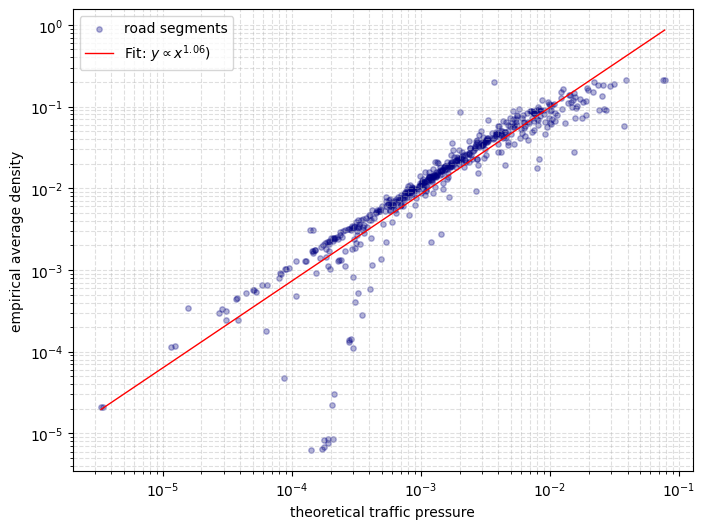

np.float64(1.0632079570802455)

In [23]:
def plot_log_log_regression(G, df_results):
    '''
    plots a log-log regression of traffic pressure vs empirical density.
    calculates the power law exponent (slope).

    parameters:
      G (networkx object): road network.
      df_results (pandas dataframe): empirical results.

    returns:
      slope (float): power law exponent.
    '''

    # calculate pressur (theoretical metric)
    edge_bet = nx.edge_betweenness_centrality(G, weight='length')
    data = []

    # iterate through edges and compute the metric for each one
    for u, v, k, d in G.edges(data=True, keys=True):
        bet = edge_bet.get((u, v, k), edge_bet.get((u, v), 0))
        length = d.get('length', 50)
        capacity = max(1, length / 8.0)

        # metric derived in your paper
        pressure = bet / capacity

        data.append({
            'u': u, 'v': v, 'key': k,
            'pressure': pressure
        })

    # convert to dataframe for easier sorting & merging
    df_theory = pd.DataFrame(data)
    # merge theoretical and empirical results
    df = pd.merge(df_results, df_theory, on=['u', 'v', 'key'])

    # filter for log transformation
    # density must be > 0. pressure must be > 0.
    df_clean = df[(df['avg_density'] > 0) & (df['pressure'] > 0)].copy()

    # log transform
    x_log = np.log(df_clean['pressure'])
    y_log = np.log(df_clean['avg_density'])

    # linear regression on log data
    slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)

    spearman = df_clean['pressure'].corr(df_clean['avg_density'], method='spearman')
    print(f"R-Squared: {r_value**2}")
    print(f"Spearman Correlation: {spearman}")
    # print coefficient
    print(f"slope (power law exponent): {slope:.4f}")

    # generate fit line for plotting
    x_fit_log = np.linspace(x_log.min(), x_log.max(), 100)
    y_fit_log = slope * x_fit_log + intercept

    # plot
    plt.figure(figsize=(8, 6))

    # scatter plot
    plt.scatter(df_clean['pressure'], df_clean['avg_density'], alpha=0.3, color='navy', s=15, label='road segments')

    # fit line
    # y = exp(intercept) * x^slope
    x_fit = np.exp(x_fit_log)
    y_fit = np.exp(y_fit_log)
    plt.plot(x_fit, y_fit, color='red', linewidth=1, label=f'Fit: $y \\propto x^{{{slope:.2f}}}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('theoretical traffic pressure')
    plt.ylabel('empirical average density')
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.legend()
    plt.show()

    return slope

# run the code
G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
plot_log_log_regression(G, all_roads)

In [29]:
def analyze_city_prediction(place_name, num_cars=1000, exponent=1.06):
    '''
    loads a OSM city map, runs the simulation, tests the power law, and maps the hotspots.

    parameters:
      place_name (str): a city address present in osmx.
      num_cars (int): number of cars to initialize each simulation wiht.
      exponent (float): power law exponent.

    returns:
      none. plots the results.
    '''
    random.seed(11)
    print(exponent)
    print(f"analyzing: {place_name.upper()}")

    # load graph from OSM
    try: # test whether the graph name exists
        G = ox.graph_from_address(place_name, dist=1000, network_type='drive')
    except Exception as e: # return error if not in osmx
        print(f"error loading map: {e}")
        return # return nothing

    # run empirical simulation
    df_empirical, _ = run_congestion_analysis(G,
                            max_trials=1200,
                            min_trials=10,
                            convergence_tol=1e-2, # 1%
                            patience=10,
                            num_steps=100,
                            top_n=300,
                            progress_bar=True)

    # calculate theoretical metrics
    edge_bet = nx.edge_betweenness_centrality(G, weight='length')
    theory_data = []

    # iterate through all edges
    for u, v, k, d in G.edges(data=True, keys=True):
        bet = edge_bet.get((u, v, k), edge_bet.get((u, v), 0))
        length = d.get('length', 50)
        capacity = max(1, length / 9.0)

        # the metric: betweenness / capacity
        pressure = bet / capacity

        # the power law prediction
        pred_score = np.power(pressure, exponent) # using exponent as input

        # store predicted scores
        theory_data.append({
            'u': u, 'v': v, 'key': k,
            'pressure': pressure,
            'predicted_score': pred_score
        })

    # convert to pandas df
    df_theory = pd.DataFrame(theory_data)

    # merge empirical and theoretical results into single df
    df = pd.merge(df_empirical, df_theory, on=['u', 'v', 'key'])
    df = df[df['avg_density'] > 0] # filter empty roads (for log-log plot)

    # compare rankings
    df['rank_empirical'] = df['avg_density'].rank(ascending=False)
    df['rank_predicted'] = df['predicted_score'].rank(ascending=False)

    # include spearman correlation coefficient
    spearman = df['rank_empirical'].corr(df['rank_predicted'])

    slope, intercept, r_value, p_value, std_err = linregress(np.log(df['pressure']), np.log(df['avg_density']))
    r_squared = r_value**2

    # print out and compare top 15 values
    top_15_emp = set(df.sort_values('rank_empirical').head(15).index)
    top_15_pred = set(df.sort_values('rank_predicted').head(15).index)
    overlap = len(top_15_emp.intersection(top_15_pred))

    print("." *60)
    print(f"results for {place_name.upper()}")
    print(f"spearman rank correlation: {spearman:.4f}")
    print(f"r-squared: {r_squared:.4f}")

    print("." * 60)

    # scatter plot comparing empirical to theoretical
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pressure', y='avg_density', alpha=0.4, label='road segments')

    # fit line for visual check
    scale_factor = np.mean(df['avg_density'] / df['predicted_score'])
    x_range = np.linspace(df['pressure'].min(), df['pressure'].max(), 100)
    y_curve = scale_factor * np.power(x_range, exponent) # linear regression line

    # plot scatterplot
    plt.plot(x_range, y_curve, color='red', lw=1, label=f'power law ($y \\propto x^{{{exponent}}}$)')

    # log log plot
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'theoretical pressure ($p$)')
    plt.ylabel(r'empirical density ($\rho$)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.show()

    # map of top hotspots
    plot_congested_with_ranks(G, df_empirical, top_n=10)

1.06
analyzing: AV. CORRIENTES 1066, BUENOS AIRES, ARGENTINA
trial 384: max_%_change=0.7917% | stable=10/10
> strict percentage convergence reached! stopping at trial 384.

processing final dataset...

TOP CONGESTED ROADS
                   name  avg_density      length
532  Avenida 9 de Julio     0.230113   29.306618
535  Avenida 9 de Julio     0.218047   15.240648
533  Avenida 9 de Julio     0.209967   36.260857
228           Esmeralda     0.202057  128.537004
259  Avenida 9 de Julio     0.200573   17.618513
230             Piedras     0.187150   66.761117
362           Esmeralda     0.183307   30.937499
215           Esmeralda     0.182295  126.336428
540  Avenida 9 de Julio     0.181133   38.780746
39              Lavalle     0.151087   41.405860


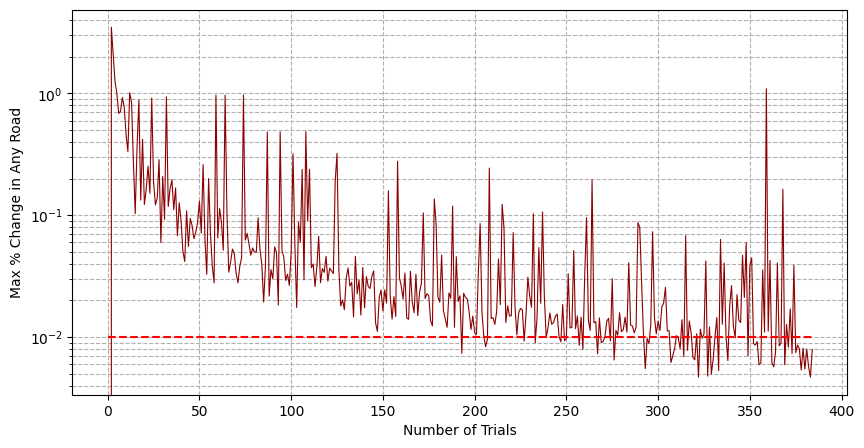

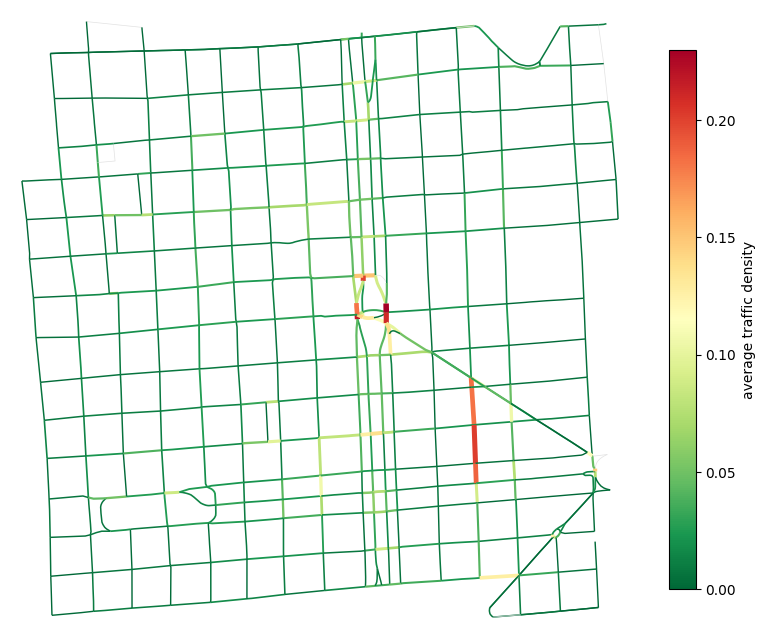

............................................................
results for AV. CORRIENTES 1066, BUENOS AIRES, ARGENTINA
spearman rank correlation: 0.9800
r-squared: 0.9213
............................................................


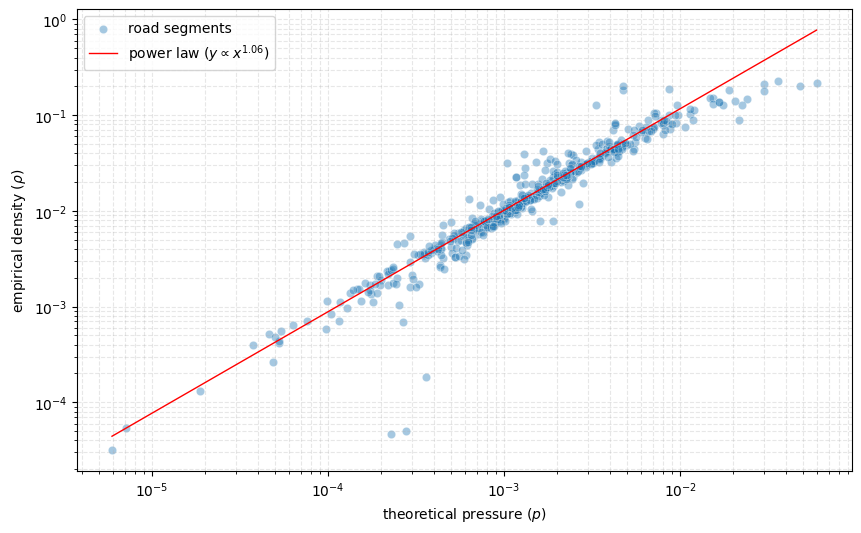

mapping top 10 hotspots (with collision avoidance)...


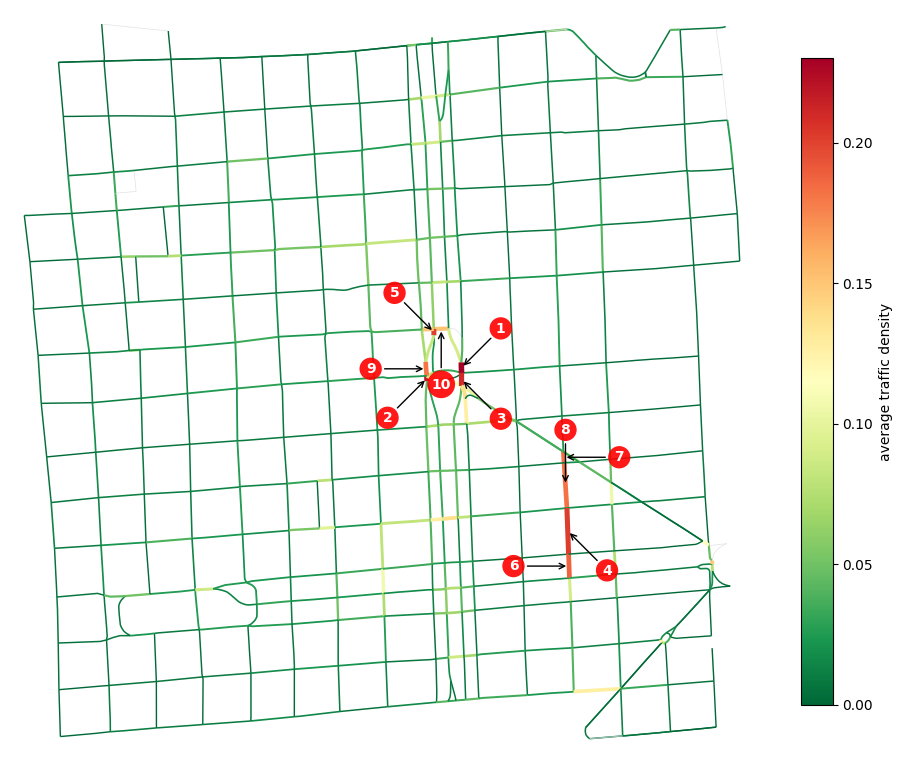

In [30]:
analyze_city_prediction("Av. Corrientes 1066, Buenos Aires, Argentina")